In [1]:
%run ./utility.ipynb

# Interpolation and Regularizers
In this notebook, we will talk about interpolating coordinate values from an image as well as calculating the regularizer
for gradient descent.

## Background on FOV and k-space
FOV stands for Field of view and it refers to the distance over which an image is acquired or displayed. These images are usually captured by some sort of signal processing like telescopes and MRIs. The FOV and pixel width determine the number of units in the fourier domain that must be obtained in order to reconstruct an image.

For the sakes of this research and example, FOV<sub>x</sub> = FOV<sub>y</sub> = FOV and $\Delta x = \Delta y = \Delta w$. Where w is the pixel width.

The Fourier projection of spatial frequencies all follow a similar pattern. Instead of regular sine waves, we see complex exponentials 
, cos n $\omega$ t + i sin n $\omega$ t. Each pair of samples lines differ by exactly 1 cycle over the FOV. This means that $\Delta k = k_{n+1} - k_n = \frac{n+1}{FOV}-\frac{n}{FOV} = \frac{1}{FOV}$


## Interpolation

In this notebook, we have an image that is being linearly transformed using fourier transforms. We do this in order to allow us to use direct comparisons between our image (in real space but being transformed into fourier space) and the data obtained by the telescopes (which are in the spectral or fourier domain.)

When doing this transformation, we obtain a grid of points extracted from the image which do not necessarily line up with the U and V coordinates from the dataset. Instead, we must interpolate or estimate the values of the data points using existing known points in our grid.

Furthermore, in order to translate correctly from image space to fourier space, we need to multiply the grids (kx and ky) by k_FOV. The calculation for this is explained above.

It is important to note that the more grid points we have, the bigger the image. Thus the size of our Fourier Domain is the Number of pixels of the image by k_FOV. If our FOV is very small, then the width of the fourier grid becomes large.

Next we want to interpolate the complex value at each coordinate. RegularGridInterpolator however cannot interpolate complex numbers so we interpolate the real and imaginary parts separately and then combined them for the final result.

Finally, we use a linear method for interpolation due to it's local interpolation scheme. The other schemes that RegularGridInterpolator offers uses a C^2-smooth split which is a non-local scheme. Since we wanted to optimize the computation time, we chose the linear method.

In [70]:
# Assumption image is 80x80 pixels
# Pass in array of u,v coords then return array of interpolated values
def interpolate(image, coords, FOV):
    """
    image is a 80x80 pixel image that represents our reconstructed image
    coords is a list of u,v coordinates that we obtained from our data
    FOV is the Field of view from the telescopes. For the EHT data, our FOV is 100 micro ascs.
    """

    ft_image = np.fft.fftshift(np.fft.fft2(image))

    k_FOV = 1/FOV

    kx = np.fft.fftshift(np.fft.fftfreq(ft_image.shape[0], d = 1/(k_FOV*ft_image.shape[0])))
    ky = np.fft.fftshift(np.fft.fftfreq(ft_image.shape[1], d = 1/(k_FOV*ft_image.shape[1])))

    interp_real = RegularGridInterpolator((kx, ky), ft_image.real, bounds_error=False, method="linear")
    interp_imag = RegularGridInterpolator((kx, ky), ft_image.imag, bounds_error=False, method="linear")

    real = interp_real(coords)
    imag = interp_imag(coords)

    return real + imag * 1j

Here we do some tests using interp_real and interp_imag to verify that they do interpolate a value using a linear scheme. First we start with a very basic 5x5 grid.

In [59]:
x = [0,1,2,3,4]
y = [0,1,2,3,4]
z = [[1,1,1,1,1],[2,2,2,2,2],[3,3,3,3,3],[4,4,4,4,4],[5,5,5,5,5]]
interp = RegularGridInterpolator((x,y),z)
print("Expected: 1, Actual:", interp([0,3]))
print("Expected: 2.5, Actual:", interp([1.5,2.5]))

Expected: 1, Actual: [1.]
Expected: 2.5, Actual: [2.5]


Now, here is a test on a fourier transformed image

(-0.5, 179.5, 179.5, -0.5)

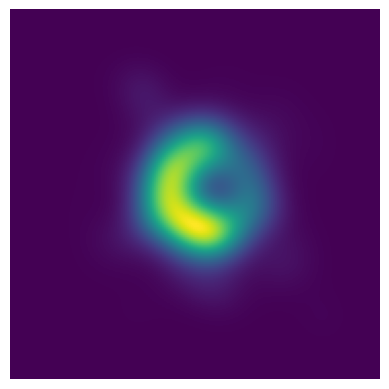

In [63]:
sample = np.loadtxt("images/interpolate_test.csv", delimiter=",")
plt.figure()
plt.imshow(sample)
plt.axis('off')

In [75]:
ft_image = np.fft.fftshift(np.fft.fft2(sample))
interpolated_points = interpolate(sample,[[-9.0e+09,-9.0e+09], [-8.9e+09,-9.0e+09] ,[-8.95e+09,-9.0e+09]],180*u.uas.to(u.rad))
print("Expected:",ft_image[0,0],"\nActual:", interpolated_points[0])
print("\nExpected:",ft_image[1,0],"\nActual:", interpolated_points[1])
print("\nExpected: ",(ft_image[1,0]+ft_image[0,0])/2,"\nActual:", interpolated_points[2])

Expected: (3.0000000019953994-2.1431905139479568e-09j) 
Actual: (3.0000000019953994-2.1431905139479568e-09j)

Expected: (38.20989061676637+0.6177808031820264j) 
Actual: (38.20989061676637+0.6177808031820264j)

Expected:  (20.604945309380888+0.30889040051941796j) 
Actual: (20.604945309380888+0.30889040051941796j)


Below is an interpolation subroutine written by Misha Stepanov.

The code provides an insight into a local interpolation scheme using 2D cubic splines. It is local in a sense that only 12 grid points around the point at which we are interpolating is used to contribute the the estimation. The code the interpolation is done with data being wrapped into a 2D torus and the xy-coordinates are supplied assuming that the step of the grid in both the x and y directions are equal to 1

### include stuff about cublic splines? Get permission first


In [10]:
def cubf1(x, y):
  cf1 = (1. + x - x*x)*(1. + 2.*y)*(1. - y)
  cf2 = (1. + y - y*y)*(1. + 2.*x)*(1. - x)
  return 0.5*(cf1 + cf2)*(1. - x)*(1. - y)
def cubf2(x, y):
  return -0.5*x*(1. - x)*(1. - x)*(1. + 2.*y)*(1. - y)*(1. - y)
def cubic12(A, X):
  N = len(A);  F = np.zeros(len(X))
  for i in range(len(X)):
    m = np.mod(X[i], N);  x, y = m - np.floor(m)
    m1, m2 = np.floor(np.mod(m + np.array([2., 2.]), N)).astype(int)
    F[i]  = A[m1 - 2, m2 - 2]*cubf1(x, y)
    F[i] += A[m1 - 1, m2 - 2]*cubf1(1. - x, y)
    F[i] += A[m1 - 2, m2 - 1]*cubf1(x, 1. - y)
    F[i] += A[m1 - 1, m2 - 1]*cubf1(1. - x, 1. - y)
    F[i] += A[m1 - 3, m2 - 2]*cubf2(x, y)
    F[i] += A[m1 - 2, m2 - 3]*cubf2(y, x)
    F[i] += A[m1    , m2 - 2]*cubf2(1. - x, y)
    F[i] += A[m1 - 1, m2 - 3]*cubf2(y, 1. - x)
    F[i] += A[m1 - 3, m2 - 1]*cubf2(x, 1. - y)
    F[i] += A[m1 - 2, m2    ]*cubf2(1. - y, x)
    F[i] += A[m1    , m2 - 1]*cubf2(1. - x, 1. - y)
    F[i] += A[m1 - 1, m2    ]*cubf2(1. - y, 1. - x)
  return F

def func(x, y):
  return np.sin(2*np.pi*x) + np.cos(2*np.pi*(x + y))

In [76]:
A = np.zeros((10, 10))
for i in range(10):
  x = i / 10.
  for j in range(10):
    y = j / 10.
    A[i, j] = func(x, y)

X = np.zeros((10000, 2))
for i in range(10000):
  X[i, 0] = i / 1000.
  X[i, 1] = i / 2000.
F = cubic12(A, X)
for i in range(10000-10,10000):
  print(X[i, 0], X[i, 1], F[i], func(X[i, 0] / 10., X[i, 1] / 10.))

9.99 4.995 -1.0058598083263428 -1.0062387310745087
9.991 4.9955 -1.0052755185370548 -1.0056188621460636
9.992 4.996 -1.004690839850659 -1.0049981027528014
9.993 4.9965 -1.0041057771382442 -1.0043764531360648
9.994 4.997 -1.0035203352965503 -1.0037539135379836
9.995 4.9975 -1.0029345192480468 -1.0031304842014765
9.996 4.998 -1.002348333941004 -1.002506165370251
9.997 4.9985 -1.001761784349569 -1.0018809572888083
9.998 4.999 -1.001174875473833 -1.0012548602024367
9.999 4.9995 -1.0005876123399073 -1.0006278743572115


## Regularization
Here we start to calculate regularizers. We do so in order to smooth image and add some bias into the model to prevent it from overfitting the training data. Regularizers allow machine learning models to generalize to new examples that it has not seen during training.

The regularizer below implements a regularization method called "total squared variation." This method favors smooth edges and is often used for astronomical image reconstruction.

The formula for a TSV regularizer is 

$-\sum_l \sum_m[(I_{l+1,m}-I_{l,m})^2+(I_{l,m+1}-I_{l,m})^2]$ 

where l and m are pixel coordinates and I is the image. There are however other similar regularizers like Total variation that favors pixel-to-pixel smoothness.

In [3]:
# p is the exponent of the regularizing terms
# The smaller p the more sensitive it is to noise
# TSV = Total Squared Variation
def calc_regularizer(image: np.array, tsv=False, p=None):
    if tsv and p == None:
        raise Exception("p value not set")
    reg = 0
    if tsv:
        image_lshift = np.copy(image, subok=True)
        image_lshift = np.roll(image_lshift, -1,axis=1)
        image_lshift[:,-1] = image_lshift[:,-2] 
        image_upshift = np.copy(image, subok=True)
        image_upshift = np.roll(image_upshift, -1, axis=0)
        image_upshift[-1] = image_upshift[-2] 

        term_1 = np.power(np.absolute(np.subtract(image_lshift, image)),p)
        term_2 = np.power(np.absolute(np.subtract(image_upshift, image)),p)
        reg = np.sum(np.add(term_1,term_2))
    return -1 * reg

Here we test the calc_regulaizer function using an empty image, a monotone image, and a noisy image.

(-0.5, 79.5, 79.5, -0.5)

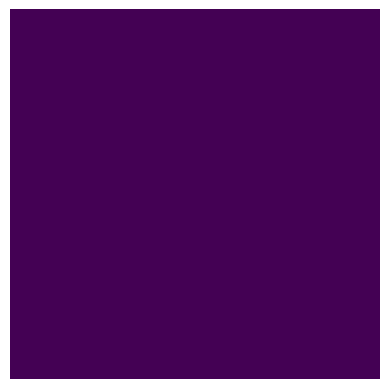

In [4]:
empty_image = np.zeros((80,80)) 
plt.figure()
plt.imshow(empty_image, vmin=0, vmax=1)
plt.axis('off')

(-0.5, 79.5, 79.5, -0.5)

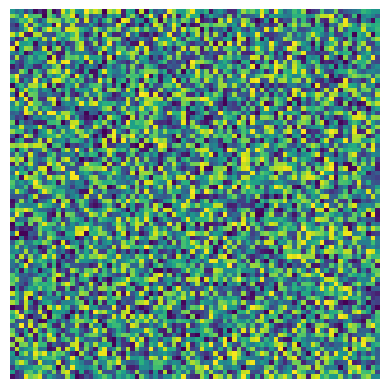

In [5]:
noisy_image = np.random.rand(80,80)
plt.figure()
plt.imshow(noisy_image, vmin=0, vmax=1)
plt.axis('off')

(-0.5, 79.5, 79.5, -0.5)

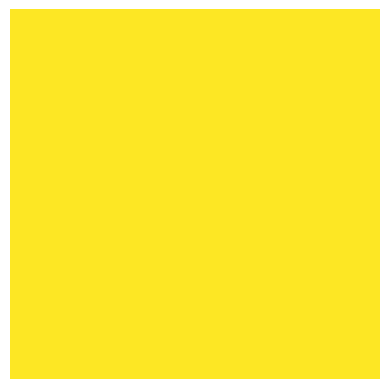

In [6]:
monotone_image = np.full((80,80), 1)
plt.figure()
plt.imshow(monotone_image, vmin=0, vmax=1)
plt.axis('off')

In [7]:
print("Empty:",calc_regularizer(empty_image,True,2))
print("Noisy:",calc_regularizer(noisy_image,True,2))
print("Monotone:",calc_regularizer(monotone_image,True,2))

Empty: -0.0
Noisy: -2134.3089281754687
Monotone: 0


Here we see that the regularizer favors smooth images over noisy/rough ones. It is important to note that both the empty image and the monotone image have a regularizer of 0. This is because we weight the images towards smoother images.

This is the gradient of the regularizer.
We calculate each point in the picture by doing $x_{i+1,j} + x_{i-1,j} + x_{i,j+1} + x_{i,j-1} - 4x_{i,j}$ for each i,j pixels

In [77]:
def gradient_regularizer(image: np.array):
    image_lshift = np.copy(image, subok=True)
    image_lshift = np.roll(image_lshift, -1,axis=1)
    image_lshift[:,-1] = image_lshift[:,-2] 
    image_upshift = np.copy(image, subok=True)
    image_upshift = np.roll(image_upshift, -1, axis=0)
    image_upshift[-1] = image_upshift[-2] 
    image_rshift = np.copy(image, subok=True)
    image_rshift = np.roll(image_rshift, 1,axis=1)
    image_rshift[:,0] = image_rshift[:,1] 
    image_dshift = np.copy(image, subok=True)
    image_dshift = np.roll(image_dshift, 1, axis=0)
    image_dshift[0] = image_lshift[1] 
    g_reg = 4 * image - image_lshift - image_upshift - image_rshift - image_dshift
    return g_reg

In [78]:
print("Empty:\n",gradient_regularizer(empty_image))
print("Noisy:\n",gradient_regularizer(noisy_image))
print("Monotone:\n",gradient_regularizer(monotone_image))

Empty:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Noisy:
 [[-0.32547852 -0.66869111 -0.05481815 ...  0.30586952  0.24106889
   0.42663812]
 [ 0.94831606  0.71867537 -1.1352365  ...  0.26432028  0.38282251
  -0.66627423]
 [-0.52432344 -0.06047219  0.9131417  ... -0.45659833 -1.8477806
   0.84171208]
 ...
 [-1.01182793  0.80009527 -0.6243269  ... -1.75949521  1.29972978
   0.20145293]
 [ 1.31363085 -1.00845911 -0.44380048 ...  0.22332234  1.27974187
  -1.15841071]
 [-0.62026661  0.07337497 -0.73596549 ...  0.66592972 -0.81457139
   0.30699282]]
Monotone:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
